Training data size: torch.Size([60000, 28, 28])
Training labels size: torch.Size([60000])


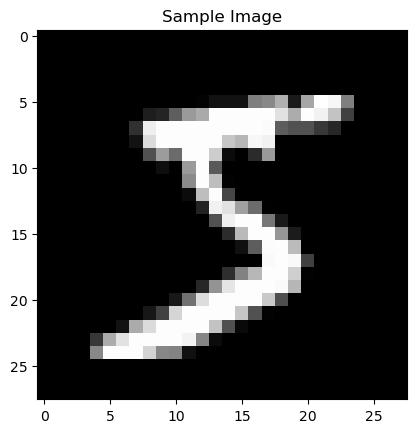

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch: 0 | Step: 0 | Train Loss: 2.3034 | Test Accuracy: 0.1210
Epoch: 0 | Step: 100 | Train Loss: 0.5555 | Test Accuracy: 0.8680
Epoch: 0 | Step: 200 | Train Loss: 0.1272 | Test Accuracy: 0.9345
Epoch: 0 | Step: 300 | Train Loss: 0.0559 | Test Accuracy: 0.9495
Epoch: 0 | Step: 400 | Train Loss: 0.0345 | Test Accuracy: 0.9575
Epoch: 0 | Step: 500 | Train Loss: 0.1839 | Test Accuracy: 0.9665
Epoch: 0 | Step: 600 | Train Loss: 0.0191 | Test Accuracy: 0.9710
Epoch: 0 | Step: 700 | Train Loss: 0.0962 | Test Accuracy: 0.9660
Ep

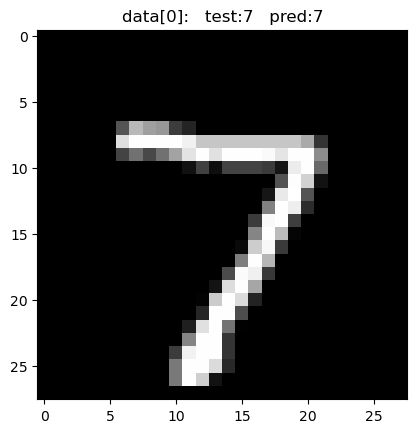

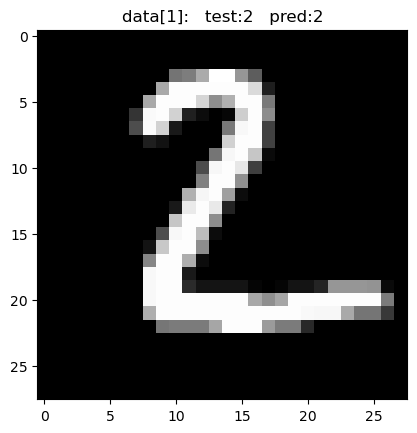

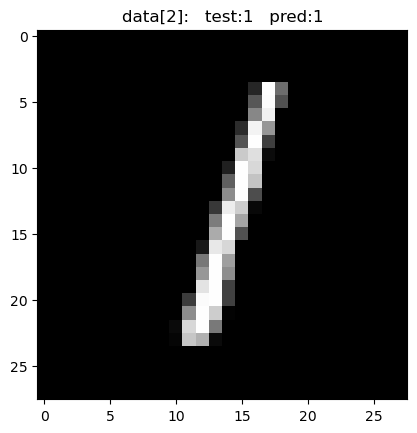

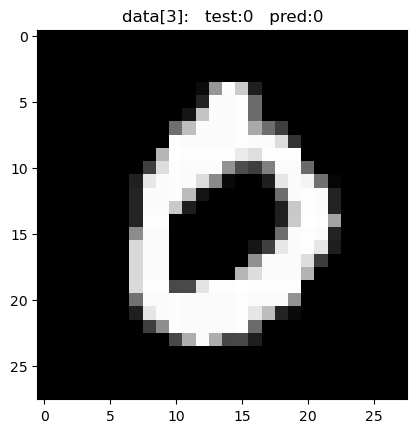

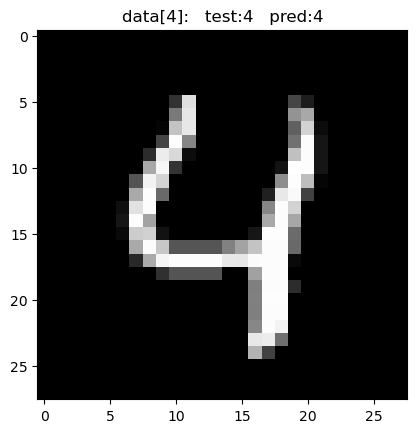

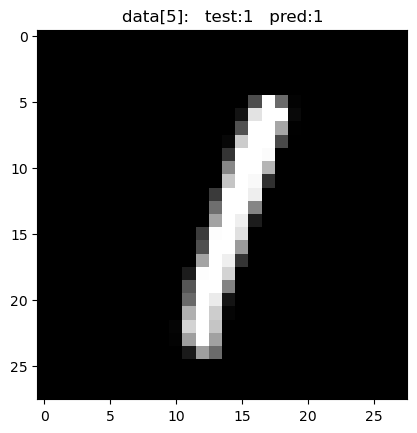

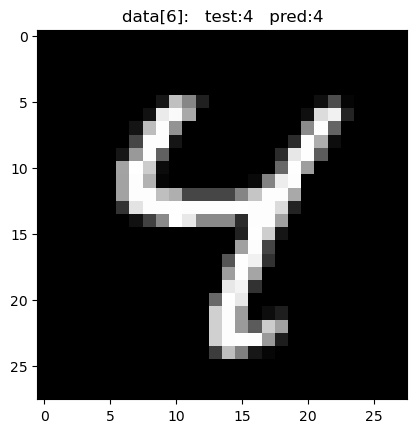

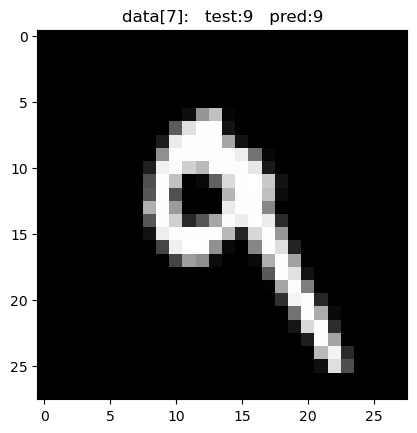

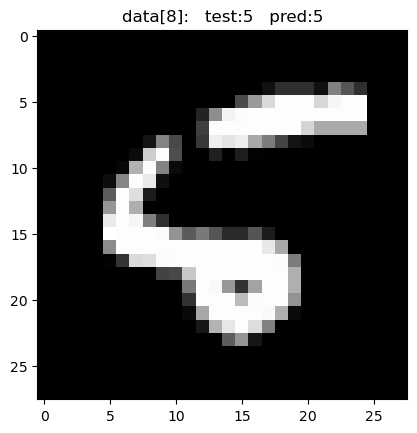

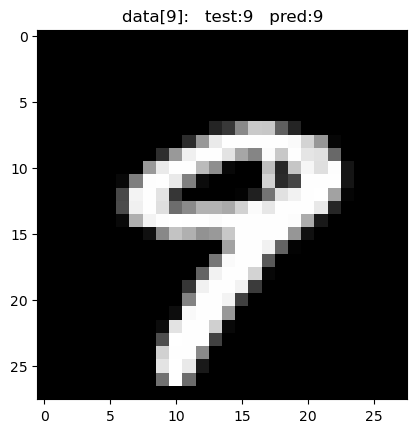

In [2]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

# 设置随机种子，以确保实验结果的可重复性
torch.manual_seed(1)

# 超参数
EPOCH = 2  # 训练轮数
BATCH_SIZE = 50  # 每个批次的数据量
LR = 0.001  # 学习率
DOWNLOAD_MNIST = True  # 是否下载数据集

# 获取 MNIST 训练数据集
training_data = torchvision.datasets.MNIST(
    root='./data/',  # 数据集存储路径
    train=True,  # 表示获取训练集数据
    transform=torchvision.transforms.ToTensor(),  # 将图像转换为 Tensor 并归一化到 [0, 1] 范围
    download=DOWNLOAD_MNIST,  # 是否下载数据集
)

# 打印训练集数据的尺寸
print('Training data size:', training_data.data.size())  # torch.Size([60000, 28, 28])
print('Training labels size:', training_data.targets.size())  # torch.Size([60000])

# 显示一张训练图像
plt.imshow(training_data.data[0].numpy(), cmap='gray')
plt.title('Sample Image')
plt.show()

# 创建数据加载器，用于批量加载数据
train_loader = Data.DataLoader(dataset=training_data, batch_size=BATCH_SIZE, shuffle=True)

# 获取 MNIST 测试数据集
test_data = torchvision.datasets.MNIST(root='./data/', train=False)

# 取前 2000 个测试集样本进行测试
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000] / 255
test_y = test_data.targets[:2000]

# 定义卷积神经网络模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 定义第一个卷积块
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),  # 卷积层
            nn.ReLU(),  # ReLU 激活函数
            nn.MaxPool2d(kernel_size=2)  # 最大池化层，窗口大小 2x2
        )
        # 定义第二个卷积块
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),  # 卷积层
            nn.ReLU(),  # ReLU 激活函数
            nn.MaxPool2d(2)  # 最大池化层，窗口大小 2x2
        )
        # 定义全连接层，输出 10 个类别的概率
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)  # 前向传播通过第一个卷积块
        x = self.conv2(x)  # 前向传播通过第二个卷积块
        x = x.view(x.size(0), -1)  # 将 (batch_size, 32, 7, 7) 展平为 (batch_size, 32*7*7)
        output = self.out(x)  # 前向传播通过全连接层
        return output

# 实例化模型
cnn = CNN()
print(cnn)  # 打印模型结构

# 定义优化器和损失函数
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)  # Adam 优化器
loss_function = nn.CrossEntropyLoss()  # 交叉熵损失函数

# 训练模型
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = x  # Tensor 类型，不需要 Variable
        b_y = y  # Tensor 类型，不需要 Variable

        # 前向传播
        output = cnn(b_x)
        loss = loss_function(output, b_y)  # 计算损失

        # 反向传播和优化
        optimizer.zero_grad()  # 清除梯度
        loss.backward()  # 计算梯度
        optimizer.step()  # 更新参数

        # 每 100 个批次打印一次训练损失和测试集准确率
        if step % 100 == 0:
            with torch.no_grad():  # 禁用梯度计算
                test_output = cnn(test_x)  # 测试集前向传播
                pred_y = torch.max(test_output, 1)[1].data  # 预测结果
                accuracy = (pred_y == test_y).sum().item() / len(test_y)  # 计算准确率
                print(f'Epoch: {epoch} | Step: {step} | Train Loss: {loss.item():.4f} | Test Accuracy: {accuracy:.4f}')

# 测试模型并可视化结果
with torch.no_grad():  # 禁用梯度计算
    test_output = cnn(test_x[:10])  # 对前 10 个测试样本进行预测
    pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()  # 预测结果
    print(pred_y, 'Prediction Numbers')
    print(test_y.numpy()[:10], 'Real Numbers')

    # 可视化测试样本及其预测结果
    for n in range(10):
        plt.imshow(test_data.data[n].numpy(), cmap='gray')
        plt.title(f'data[{n}]:   test:{test_data.targets[n]}   pred:{pred_y[n]}')
        plt.show()
